In [1]:
import json
import time
import random
import pymongo
import copy
import MyCommon
from pymongo import MongoClient
from collections import deque
import cassiopeia
from cassiopeia import riotapi
import numpy as np
from sklearn import preprocessing, cluster, decomposition
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import FastICA, PCA
from sklearn import metrics
import requests
from bs4 import BeautifulSoup

riotapi.set_region("KR")
riotapi.set_api_key("79428a9e-5d98-469b-9b9b-429c1a750d24")
riotapi.set_rate_limits((10, 10), (500, 600))
riotapi.print_calls(True)

client = MongoClient()
loladb = client.loladb
summoners_collection = loladb.summoners
matches_collection = loladb.matches
print summoners_collection.count()
print matches_collection.count()

champions = riotapi.get_champions()
dict_id2idx = dict()
dict_idx2id = dict()
dict_id2key = dict()
for a_idx, a_champion in enumerate(champions):
    champ_id = a_champion.id
    champ_key = a_champion.key
    dict_id2idx[champ_id] = a_idx
    dict_idx2id[a_idx] = champ_id
    dict_id2key[champ_id] = champ_key
    
#print dict_id2key[dict_idx2id[132]]
#print dict_id2key

def GetIdxFromId(a_id):
    return dict_id2idx[a_id]

def GetIdFromIdx(a_idx):
    return dict_idx2id[a_idx]

def GetNameFromId(a_id):
    return dict_id2key[a_id]

CHAMP_NUM = len(champions)

1255
25451
https://global.api.pvp.net/api/lol/static-data/kr/v1.2/champion?champData=all&api_key=79428a9e-5d98-469b-9b9b-429c1a750d24
https://global.api.pvp.net/api/lol/static-data/kr/v1.2/item?itemListData=all&api_key=79428a9e-5d98-469b-9b9b-429c1a750d24


In [2]:
def GetTierFromOPGG():
    #how to get a summoner's rank/division quickly
    for a_idx, a_summoner in enumerate(summoners_collection.find()):
        if a_idx < 12:
            continue
        summoner_detail = riotapi.get_summoner_by_id(a_summoner['playerOrTeamId'])  
        print summoner_detail.to_json()
        #print MyCommon.JSONEncoder().encode(a_summoner)
        #print a_summoner['playerOrTeamName']
        summonerURL = "http://www.op.gg/summoner/userName=" + summoner_detail.name
        print summonerURL
        result = requests.get(summonerURL)
        soup = BeautifulSoup(result.content, 'html.parser')
        tier_part = soup.find("div", { "class" : "TierRank" })
        tier_text = tier_part.getText()
        print tier_text
        tier = tier_text.split()[0]
        summoners_collection.update_one({'playerOrTeamId':a_summoner['playerOrTeamId']}, {'$set': {'soloTier': tier}})
        print a_idx


In [3]:
version_count = 0
for a_idx, a_match in enumerate(matches_collection.find({})):
    if a_match['matchVersion'].startswith('6.24'):
        version_count += 1
    if a_idx % 1000 == 0:
        print a_idx
print version_count
#15000 match of 6.24

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
16389


In [5]:
summoner_id2idx = dict()
summoner_idx2id = dict()

for a_idx, a_summoner in enumerate(summoners_collection.find()):
    summoner_id = a_summoner['playerOrTeamId']
    summoner_id2idx[summoner_id] = a_idx
    summoner_idx2id[a_idx] = summoner_id

def Summoner_GetIdxFromId(a_id):
    return summoner_id2idx[a_id]

def Summoner_GetIdFromIdx(a_idx):
    return summoner_idx2id[a_idx]

print len(summoner_idx2id)

SUMMONER_NUM = summoners_collection.count()

1255


In [6]:
#try to use 5000 matches to get summoner winrate
#use 5000 to train classifier
#use 5000 to test

#1 统计数据库中的1255个summoners，在前5000场比赛中各英雄的游戏场次和胜利场次
winMatchMat = np.zeros((SUMMONER_NUM, CHAMP_NUM))
allMatchMat = np.zeros((SUMMONER_NUM, CHAMP_NUM))

STATS_NUM = 5000
stats_count = 0
end_idx = 0
for a_idx, a_match in enumerate(matches_collection.find({})):
    if a_idx % 1000  == 0:
        print a_idx
        
    if a_match['matchVersion'].startswith('6.24') == False:
        continue
    
    winning_side = -1
    if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
        winning_side = 0
    if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
        winning_side = 1 
    if winning_side == -1:
        continue #do not count draw game, if any

    a_duration = a_match['matchDuration']
    a_minute = a_duration/60
    if a_minute < 20:
        continue #do not count remake game
        
    stats_count += 1
    participants = a_match['participants']  
    for a_participant_idx,a_participantIdentity in enumerate(a_match['participantIdentities']):
        summoner_Id = a_participantIdentity['player']['summonerId']
        if str(summoner_Id) in summoner_id2idx.keys():
            participantIdx = summoner_id2idx[str(summoner_Id)]
            champId = participants[a_participant_idx]['championId']
            if champId == 164:
                continue
            champIdx = GetIdxFromId(champId)
            
            my_side = 0
            if a_participant_idx >= 5:
                my_side = 1
            isWinning = my_side == winning_side
            
            if isWinning == True:
                winMatchMat[participantIdx, champIdx] += 1
            allMatchMat[participantIdx, champIdx] += 1
            
    if stats_count >= STATS_NUM:
        end_idx = a_idx
        break

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [90]:
#get the tier score for each summoners
def GetTierScore(tier, division):
    score = 0
    if tier == 'Silver':
        score += 1
    if tier == 'Gold':
        score += 2
    if tier == 'Platinum':
        score += 3
    if tier == 'Diamond':
        score += 4
    if tier == 'Master':
        score += 5
    if tier == 'Challenger':
        score += 6

    return score

summoner_tiers = np.zeros(SUMMONER_NUM)
for a_idx, a_summoner in enumerate(summoners_collection.find()):
    tier = a_summoner['soloTier']
    division = a_summoner['division']
    score = GetTierScore(tier, division)
    summoner_tiers[a_idx] = score
    if a_idx % 100 == 0:
        print a_idx
MEAN_TIER = np.mean(summoner_tiers)
print MEAN_TIER

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
3.12749003984


In [16]:
summoner_match_numbers = np.zeros(SUMMONER_NUM)
summoner_rates = np.zeros(SUMMONER_NUM)
for a_summoner in summoners_collection.find():
    summoner_id = a_summoner['playerOrTeamId']
    summoner_idx = Summoner_GetIdxFromId(summoner_id)
    print a_summoner['playerOrTeamName']
    win_sum = sum(winMatchMat[summoner_idx, :])
    all_sum = sum(allMatchMat[summoner_idx, :])
    print win_sum/all_sum
    print all_sum
    summoner_match_numbers[summoner_idx] = all_sum
    if all_sum == 0:
        summoner_rates[summoner_idx] = 0.5
    else:
        summoner_rates[summoner_idx] = win_sum/all_sum


순범임
0.0
1.0
Bumgyu
nan
0.0
Creative Self
0.590909090909
66.0
종하긔
0.586956521739
46.0
Rokujo Miharu
nan
0.0
DafTnT
nan
0.0
APK X1an
0.478260869565
23.0
KDM Roach
0.0
1.0
KnightOfZer0
0.666666666667
12.0
nisaS
1.0
1.0
LC wangchen
nan
0.0
ouxinidie
0.485714285714
35.0
Twitch TV Lauren
0.451612903226
31.0
Asuna Yuuki
nan
0.0
bademan
nan
0.0
xiao BaBi
0.552631578947
38.0
크림피자
0.363636363636
11.0
Killuaaa
0.555555555556
27.0
Lovely Hyeogi
0.2
5.0
중앙대예술대학생
nan
0.0
급식냠냠냠
0.0
2.0
새우까주새우
0.470588235294
17.0
111111111110
0.518518518519
27.0
안녕하십니까유
0.552631578947
38.0
Refrain New
0.333333333333
9.0
IMamazingJ
0.5
8.0
Tv시청중
nan
0.0
블라디버프좀
0.612903225806
31.0
일 편
0.439024390244
41.0
개쌘형님
nan
0.0
Uniq R Riel
0.5
28.0
Alpago
nan
0.0
노력할 수 있을까
nan
0.0
소유진
0.142857142857
7.0
Never lazy
0.636363636364
11.0
시이남친
0.411764705882
17.0
Sans Chara
1.0
2.0
jessejesiz
nan
0.0
하이딘is뭔들
nan
0.0
Loveyx
nan
0.0
1994 09 23
nan
0.0
다수결의 원칙
nan
0.0
SSN DEFT
0.444444444444
9.0
너 아름다워
nan
0.0
기사님의모범승객
0.4
15.0
안돼오빵가지마잉
0

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


nan
0.0
영 달
nan
0.0
owo ovo
nan
0.0
Roarz
nan
0.0
너의 스킬 가볍다
0.447368421053
38.0
tacccccc
0.58
50.0
icestrom
0.391304347826
23.0
나유준
0.421052631579
19.0
이기자 할수있다
nan
0.0
병든 햄스터
nan
0.0
소용업소용
0.4375
16.0
Detta
0.630434782609
46.0
7362
0.428571428571
14.0
Raoss
nan
0.0
소금이짜요짜요
0.0
2.0
APK Aggro
0.5
6.0
a123b456
nan
0.0
서폿가는 온이
nan
0.0
IIIIIIIIIIIlIlI
0.5
6.0
이마딘
0.488372093023
43.0
최통령각하
0.346153846154
26.0
강철의 연금술4
0.888888888889
9.0
AzEvIrMnQjUfYbCx
nan
0.0
예비군6년차명수
nan
0.0
8 Y
nan
0.0
경민 박
0.6
5.0
카페베네우유도둑
nan
0.0
Koret
0.380952380952
21.0
시 넝
0.380952380952
21.0
7h Evi
0.642857142857
14.0
Shako
nan
0.0
쿤냐앙
0.5
2.0
마스터혐오증
nan
0.0
LGD pyl1
0.521739130435
46.0
Going Now
nan
0.0
효월의 원무곡
nan
0.0
부캐키우면안돼냐
0.0
3.0
섭마 논데이트
0.0
1.0
팔딱새우
0.586206896552
29.0
갓셔틀
0.555555555556
36.0
alivaS
nan
0.0
야요이는 내 여친
0.571428571429
14.0
마타마타마타마타
nan
0.0
동쁜이
0.333333333333
6.0
서포터초아
0.424242424242
66.0
The shy
nan
0.0
정호진복
0.444444444444
27.0
나 징짜 개못해
0.515151515152
33.0
SloveTheProblem
nan
0.0
Gjasmine
0.4

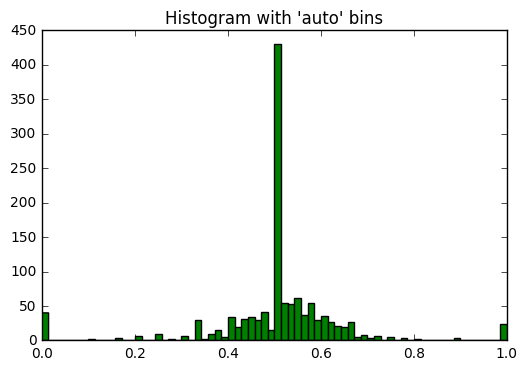

In [17]:
import matplotlib.pyplot as plt

plt.hist(summoner_rates, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [18]:
MEAN_MATCH_NUM = np.mean(summoner_match_numbers)

In [93]:
allRoles = ['TOP_SOLO', 'JUNGLE_NONE', 'MIDDLE_SOLO', 'BOTTOM_DUO_CARRY', 'BOTTOM_DUO_SUPPORT']

def IsNormalTeam(participantRoles):
    if len(participantRoles) != 5:
        return False
    
    haveAll = True
    
    for i in range(5):
        if allRoles[i] not in participantRoles:
            haveAll = False
            break
    return haveAll

def GetRoleIdx(role):
    for a_idx,a_role in enumerate(allRoles):
        if a_role == role:
            return a_idx
    return -1

def CollectTrainingSet(TRAIN_NUM, end_idx):
    #end_idx is where the previous step ended
    Train_X = np.zeros((TRAIN_NUM * 2, 10 * 3))#blue_rate blue_all blue_tier red_rate red_all red_tier
    Train_Y = np.zeros(TRAIN_NUM * 2)

    train_count = 0
    train_end_idx = 0
    for a_idx, a_match in enumerate(matches_collection.find({})):  
        if a_idx % 1000  == 0:
            print a_idx

        if a_idx < end_idx:
            continue

        if a_match['matchVersion'].startswith('6.24') == False:
            continue

        winning_side = -1
        if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
            winning_side = 0
        if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
            winning_side = 1 
        if winning_side == -1:
            continue #do not count draw game, if any

        a_duration = a_match['matchDuration']
        a_minute = a_duration/60
        if a_minute < 20:
            continue #do not count remake game

        participants = a_match['participants']  
        participantRoles = [p['timeline']['lane'] + '_' + p['timeline']['role'] for p in participants]
                            
        blueRoles = participantRoles[0:5]
        redRoles = participantRoles[5:10]
        
        if IsNormalTeam(blueRoles) == False:
            continue
        if IsNormalTeam(redRoles) == False:
            continue

        has164 = False  
        for a_participant in participants:    
            if a_participant['championId'] == 164:
                has164 = True
        if has164:
            continue

        if train_count % 100 == 0:
            print "Train_Count:" + str(train_count)

        for a_participant_idx,a_participantIdentity in enumerate(a_match['participantIdentities']):
            summoner_Id = a_participantIdentity['player']['summonerId']
            champId = participants[a_participant_idx]['championId']
            champIdx = GetIdxFromId(champId)
            roleIdx = GetRoleIdx(participantRoles[a_participant_idx])

            my_side = 0
            if a_participant_idx >= 5:
                my_side = 1

            if str(summoner_Id) in summoner_id2idx.keys():
                participantIdx = summoner_id2idx[str(summoner_Id)]
                Train_X[train_count, roleIdx + my_side * 15] = summoner_rates[participantIdx]
                Train_X[train_count, roleIdx + my_side * 15 + 5] = summoner_match_numbers[participantIdx]
                Train_X[train_count, roleIdx + my_side * 15 + 10] = summoner_tiers[participantIdx]#tier
            else:
                #use average value to fill
                Train_X[train_count, roleIdx + my_side * 15] = 0.5
                Train_X[train_count, roleIdx + my_side * 15 + 5] = MEAN_MATCH_NUM
                Train_X[train_count, roleIdx + my_side * 15 + 10] = MEAN_TIER

        Train_Y[train_count] = winning_side

        #change side and count as another match
        Train_X[train_count + TRAIN_NUM, 0:15] = Train_X[train_count, 15:30]
        Train_X[train_count + TRAIN_NUM, 15:30] = Train_X[train_count, 0:15]
        Train_Y[train_count + TRAIN_NUM] = 1 - winning_side

        train_count += 1

        if train_count >= TRAIN_NUM:
            train_end_idx = a_idx
            break
    return Train_X, Train_Y, train_end_idx

Train_X, Train_Y, train_end_idx = CollectTrainingSet(5000, end_idx)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Train_Count:0
Train_Count:100
Train_Count:200
12000
Train_Count:300
Train_Count:400
Train_Count:500
Train_Count:600
Train_Count:700
Train_Count:800
Train_Count:900
Train_Count:1000
13000
Train_Count:1100
Train_Count:1200
Train_Count:1300
Train_Count:1400
Train_Count:1500
Train_Count:1600
Train_Count:1700
14000
Train_Count:1800
Train_Count:1900
Train_Count:2000
Train_Count:2100
Train_Count:2200
Train_Count:2300
Train_Count:2400
15000
Train_Count:2500
Train_Count:2600
Train_Count:2700
Train_Count:2800
Train_Count:2900
Train_Count:3000
Train_Count:3100
Train_Count:3200
16000
Train_Count:3300
Train_Count:3400
Train_Count:3500
Train_Count:3600
Train_Count:3700
Train_Count:3800
Train_Count:3900
17000
Train_Count:4000
Train_Count:4100
Train_Count:4200
Train_Count:4300
Train_Count:4400
Train_Count:4500
Train_Count:4600
18000
Train_Count:4700
Train_Count:4800
Train_Count:4900


In [94]:
print end_idx
print train_end_idx

11614
18980


In [95]:
print Train_Y[0:10]

[ 0.  1.  0.  1.  1.  1.  0.  1.  1.  1.]


In [96]:
from sklearn import datasets, linear_model

regr = linear_model.LogisticRegression()
regr.fit(Train_X, Train_Y)
Eval_Y = regr.predict(Train_X)
print Eval_Y[0:10]

[ 0.  1.  0.  1.  0.  0.  1.  1.  1.  0.]


In [97]:
Result_Y = Eval_Y == Train_Y
print sum(Result_Y)

5726


In [37]:
print len(Result_Y)

10000


In [98]:
Test_X, Test_Y, test_end_idx = CollectTrainingSet(3000, train_end_idx)
Test_X = Test_X[0:3000, :]
Test_Y = Test_Y[0:3000]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
Train_Count:0
19000
Train_Count:100
Train_Count:200
Train_Count:300
20000
Train_Count:400
Train_Count:500
Train_Count:600
Train_Count:700
Train_Count:800
Train_Count:900
21000
Train_Count:1000
Train_Count:1100
Train_Count:1200
Train_Count:1300
22000
Train_Count:1400
Train_Count:1500
Train_Count:1600
Train_Count:1700
Train_Count:1800
23000
Train_Count:1900
Train_Count:2000
Train_Count:2100
24000
Train_Count:2200
Train_Count:2300
Train_Count:2400
Train_Count:2500
Train_Count:2600
25000
Train_Count:2700
Train_Count:2800
Train_Count:2900


In [99]:
print Test_X.shape
print Test_Y.shape

(3000, 30)
(3000,)


In [100]:

Eval_Y = regr.predict(Test_X)
print Test_Y[0:10]
print Eval_Y[0:10]

Result_Y = Eval_Y == Test_Y
print sum(Result_Y)

[ 0.  1.  0.  1.  1.  1.  0.  1.  0.  0.]
[ 1.  1.  1.  0.  0.  1.  0.  1.  0.  0.]
1613


In [108]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=10, n_estimators=20)
rfc.fit(Train_X, Train_Y)
score = rfc.score(Test_X, Test_Y)
print score

0.535333333333


In [106]:
Eval_Y = rfc.predict(Train_X)
print Train_Y[0:10]
print Eval_Y[0:10]

[ 0.  1.  0.  1.  1.  1.  0.  1.  1.  1.]
[ 0.  1.  0.  1.  0.  0.  1.  1.  1.  1.]


In [102]:
from sklearn import svm
clf = svm.SVC()
clf.fit(Train_X, Train_Y) 
score = clf.score(Test_X, Test_Y)
print score

0.553666666667


In [103]:
print Train_X[0, :]

[  0.5625       0.58974359   0.51351351   0.61818182   0.41176471  16.          39.
  37.          55.          34.           4.           4.           5.           6.
   6.           0.5          0.66666667   0.62068966   0.5          0.41666667
  18.22549801  45.          29.          18.22549801  12.           3.12749004
   6.           6.           3.12749004   6.        ]
